In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import librosa as lb
import time

import scipy.linalg
import scipy.stats

import midiutil
import warnings

from IPython.display import Audio
from IPython.display import FileLink

# plt global style
plt.style.use('bmh')
# plt.style.use('dark_background')

# Lists of pre-defined data like the names of the notes and keys
pitch_class_names = ['C', 'C-sharp', 'D', 'D-sharp', 'E', 'F', 'F-sharp', 'G', 'G-sharp', 'A', 'A-sharp', 'B']
# pitch_class_names = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

all_keys = [
    'C major', 'C minor', 'C-sharp major', 'C-sharp minor',
    'D major', 'D minor', 'D-sharp major', 'D-sharp minor',
    'E-flat major', 'E-flat minor', 'E major', 'E minor',
    'F major', 'F minor', 'F-sharp major', 'F-sharp minor',
    'G major', 'G minor', 'G-sharp major', 'G-sharp minor',
    'A-flat major', 'A-flat minor', 'A major', 'A minor',
    'A-sharp major', 'A-sharp minor', 'B-flat major', 'B-flat minor', 'B major', 'B minor'
]


def filter_repeating_elements(input_list):
    filtered_list = []
    last_element = None
    repetition_count = 0

    for element in input_list:
        if element == last_element:
            repetition_count += 1
        else:
            repetition_count = 1

        if repetition_count <= 1:
            filtered_list.append(element)

        last_element = element

    return filtered_list

 ## Using pYIN and Krumhansl-Schmuckler's key estimation algorithm for key and pitch estimation.
 
***
<!-- <p align="center">
<img src="../media/cover2.jpg" alt="Image" width="1600" height="400">
</p> -->

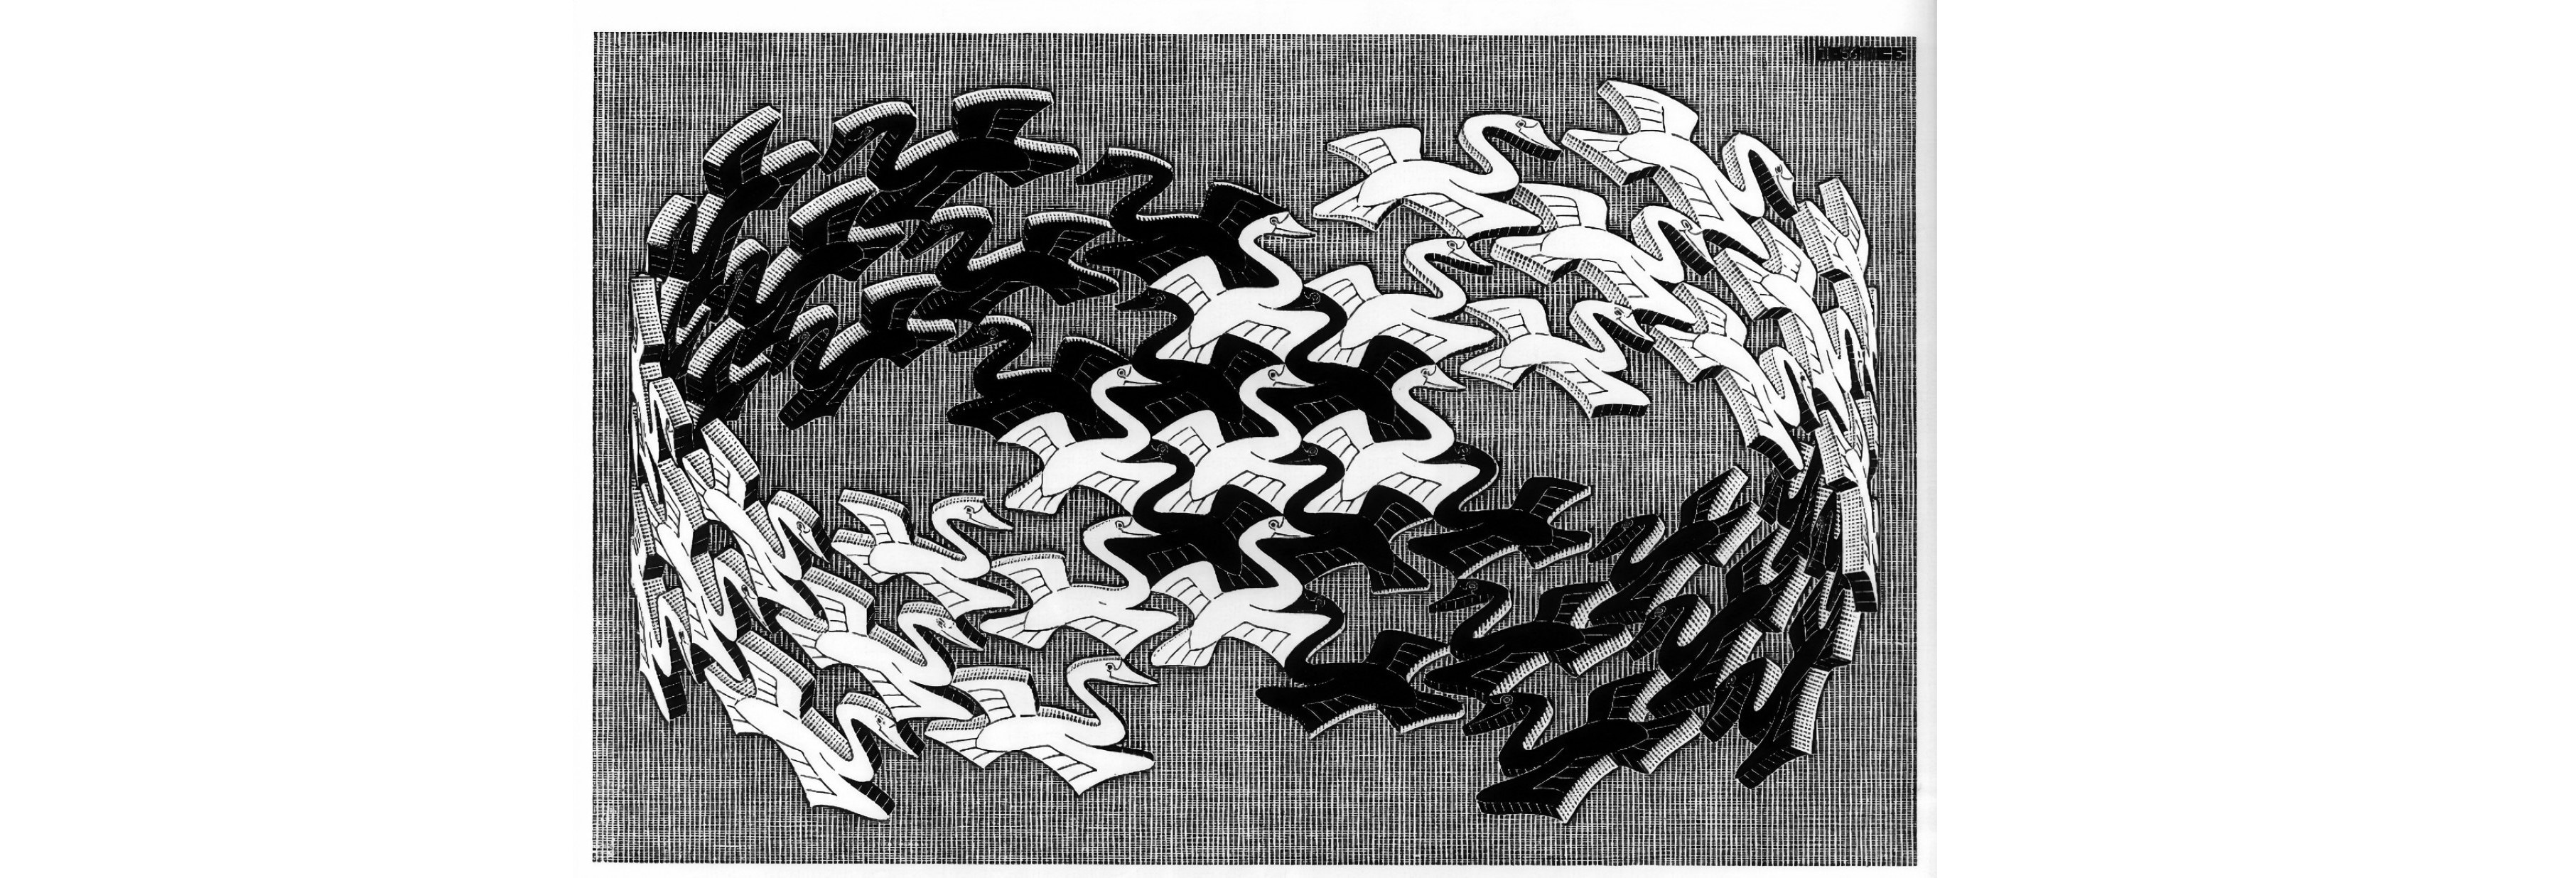


#### Content:

1. Introduction
2. Audio pre-processing
3. Key estimation using the KS algorithm 
3. Pitch estimation using pYin
4. Discussion
5. References

### 1. Introduction


<span style="color:red"> *!Read the readme!* </span>

*This project is intended to showcase the implementation and use of the two algorithms (KS, pYIN). Some basic terms are skipped and learning materials will be provided at the end.*

### Motive

Every beginner musician experience trouble when trying learn some music theory. There are a lot of notes, keys, chords, scales and modes that at first glance looks like a really difficult memory task. 

It would be really helpful for a student (or a bedroom musician) to have some simple tools for defining in what key is the song that he/she wants to learn and can't find the information on the internet. It will be even more helpful to know which notes are being played.

And for the creatives out there, who just ley their hands on their instrument and just play away without thinking, it would be nice to record their piece and in just seconds to see what key they most likely played in and which notes they used. 

So why not help them?

***

My task is to put together a working prototype for a "music helper" app. Its job will be to analyze a simple audio recording and to predict what is the key of the melody/song and which notes are being played.

The audio recording will be most likely from a phone and the composition simple, since we are targeting beginners. This means that our exact task is to create a program that accepts an audio with a simple composition and gives a prediction for the key. That's why in the testing section we will use **.wav** recordings. We are not analysing midi! We want to analyse *audio* recordings (mp3 or wav).

##### List of tasks:
1. Load recording
2. Preprocess the audio (remove silence)
3. Apply a key estimation algorithm (KS)
    - Testing and validation: KS
4. Apply a pitch detection algorithm (pYIN)
    - Testing and validation: pYIN
5. Create a class for ease of use

>Note: For the testing of the algorithms we will use a [dataset](https://www.kaggle.com/datasets/imsparsh/musicnet-dataset?select=musicnet_metadata.csv) (Musicnet) provided by SPARSH GUPTA. Results are saved in `../test_results` since the dataset is 20gb+. If one wants to download it and test the code, which is recommended, you can find it through the kaggle link I have provided in this paragraph. 



### 2. Loading audio and pre-processing

Audio preprocessing is key to reduce errors from noise and silence. We will be mainly using librosa for that. Also we will just trim the audio since denoising is a whole another can of worms outside of the scope of this notebook. 

So for now we will simply trim the silence in the audio file.

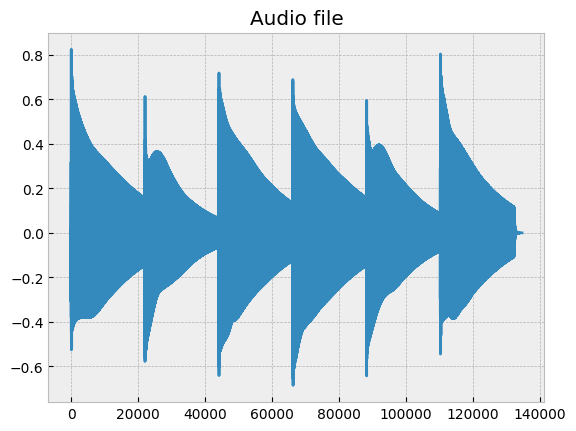

In [2]:
file = "../audio/testing/Fmin_u_u.wav"
test_audio_bass_guitar, sr_bass_guitar = lb.load(file)
test_audio_bass_guitar, _ = lb.effects.trim(test_audio_bass_guitar, top_db=57)

plt.plot(test_audio_bass_guitar)
plt.title("Audio file")
plt.show()
Audio(data=test_audio_bass_guitar, rate=sr_bass_guitar)

### 3. Key estimation using the KS algorithm

Now to the fun stuff. We will use the Krumhansl-Schmuckler's algorithm[<sup>\[1\]</sup>](#fn1) for key estimation. The reason I have chosen it is that during the course of searching for different methods and approaches to this problem I discovered that this algorithm is one of the most accurate out there besides ML. It is also cool to see how it works, since it *looks like* a little bit like ML. 

Put simply the way it works is that the code expects an array of pitch class (notes) energy distributions. Energy here is the duration of a note in seconds. So we will need a list with the sums of the durations (in seconds) of every note that is in the score. For example if we have the note C being played 3 times for duration of 0.25s in the whole song, we will have an energy distribution of 0.75 because we are summing up all the seconds. This is just the way the algorithm works. [Here](http://davidtemperley.com/wp-content/uploads/2015/11/temperley-mp99.pdf) one may find a more detailed description of it by David Temperley from Ohio State University.

To do that we will use `lb.chroma_cq`.

> `lb.chroma_cq` transforms an audio signal so that, if hypermarameters are set correctly, it can give us the notes, that have been played. It's related to Fourier transform in the sense it uses filters to give us the fundamental frequencies, but with CQ we have a **logarithmic** scale! This is even better than FT and is one of the reasons it is so well adapted for chroma analysis, since we humans perceive sound (and [other things](https://rss.onlinelibrary.wiley.com/doi/pdf/10.1111/j.1740-9713.2013.00636.x)) logarithmically as well and so logically the ntoes in the 12 tone system have logarithmic intervals.

The algorithm then calculates the correlation between the PCEN (pitch class energy distribution) of the input melody and a set of 24 predefined values (called **pitch class profiles**, more info ahead) for every key by taking the dot product. More on why dot product is the  same as correlation [here](https://dsp.stackexchange.com/questions/36309/correlation-how-is-correlation-analogous-to-dot-product). 

<!-- You can think of that as an input vector $I$ and $K_{1-24}$ as the predefined profiles. Every $K$ profile corresponds to a specific key and has 12 predefined values for the 12 notes it is made by shifting the note positions by one step, total of 12, to create the whole 24 profiles Once we have them. -->

Here is a more in depth explainetion:

First you take two sets for predefined values, calculated using different methods (more info on the methods below). Every profile has 12 values (because of the 12 tone system) and you take the dot product of the profile vector and the input vector.

Here is a basic (and not very pretty) graphic that I have made using PS. The graph shows an input vector $I$ and a preset vector $K$. In the real algorithm there will be two presets but here in the spirit of ease of understanding is just one:

<div style="text-align: center;">
    <img src="../media/Untitled-1.png" alt="Image Alt Text" style="width:45%; height:auto;">
</div>

Here if we say our input vector is the first one and we want to see if it fits the profile for B major (3rd row), we will take the dot product of the input vector and the one for B major *and voila!*

***
> The values for the `pitch class profiles` have been calculated in a **psychological** study by, Krumhansl, C. L., & Kessler, E. J, but the algorithm has been made in a separate collaboration with M. Shmuckler and Krumhansl and has been published in a book *"Cognitive Foundations of Musical Pitch*" by C. Krumhansl.
> 
> "The Krumhansl-Schmuckler key-finding algorithm is based on "key profiles." A key profile is a vector of 12 values, representing the stability of the
> 12 pitch classes relative to a given key. The key profiles were based on data
> from experiments by Krumhansl and Kessler in which subjects were asked
> to rate how well each pitch class "fit with" a prior context establishing a
> key, such as a cadence or scale" (David Temperley)[<sup>\[2\]</sup>](#fn2).
> 
> After that more profiles and variations of this approach have been made[<sup>\[2\]</sup>](#fn2).
>
> The details how the algorithm came to be can be found in chapter 17 *"Cognitive Foundations of Musical Pitch*. Link to it in Scribd is [here](https://www.scribd.com/document/73910615/Cognitive-Foundations-of-Musical-Pitch#). You can get a 30 day free trial and look it up.

We will write two functions:

`calculate_corr()` - calculate the correlation between PCEN and the profiles

`KS()` - calculates the scale with biggest correlation

In [3]:
def calculate_corr(X, profile = None):
    '''
    Adapted and modified from bmcfee's github post: https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd

    Estimate the key from a pitch class distribution using correlation scores against different key profiles.

    This function estimates the musical key from a pitch class distribution by calculating the correlation scores
    between the input distribution `X` and different key profiles. The correlation scores are calculated for major
    and minor keys.

    Parameters
    ----------
    X : np.ndarray, shape=(12,)
        Pitch-class energy distribution. Does not need to be normalized.
    profile : str or None, optional
        The profile of the pitch classes to use for correlation.
        Options: 's' for S profile, 'ks' for KS profile, 'b' for Bel profile. Default is 's'.
        More information on profiles is available at https://extras.humdrum.org/man/keycor/

    Returns
    -------
    major : np.ndarray, shape=(12,)
        Correlation scores for each key (C:maj, ..., B:maj) against the input distribution `X`.
    minor : np.ndarray, shape=(12,)
        Correlation scores for each key (C:min, ..., B:min) against the input distribution `X`.

    Notes
    -----
    The function uses pre-defined key profiles based on the chosen `profile` parameter.
    The input `X` is normalized using z-score before correlation calculation.
    The correlation scores are generated for both major and minor keys by comparing against rotated key profiles.

    The `profile` parameter can be 's' for the S profile, 'ks' for the KS profile, or 'b' for the Bel profile.
    If `profile` is None, the S profile is used by default.

    The correlation scores can be interpreted to determine the likelihood of a key's presence in the input distribution.
    Higher correlation scores indicate a stronger match between the distribution and the key profile.
    '''
    X = scipy.stats.zscore(X)
   
    # Coefficients from https://extras.humdrum.org/man/keycor/
    # Note: Best for general use and most stable is "S" or "B" as mentioned in humdrum.org
    if profile is None or profile == 's': # Standard profile
        major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1] ) 
        minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5]) 

    elif profile == 'ks': # KS profile
        major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]) 
        minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]) 
    
    elif profile == 'b': # Bel profile
        major = np.asarray([16.80, 0.86, 12.95, 1.41, 13.49, 11.93, 1.25, 20.28, 1.80, 8.04, 0.62, 10.57]) 
        minor = np.asarray([18.16, 0.69, 12.99, 13.34, 1.07, 11.15, 1.38, 21.07, 7.49, 1.53, 0.92, 10.21]) 
    
    elif profile == 'ae': # Aarden-Essen profile
        major = np.asarray([17.7661, 0.145624, 14.9265, 0.160186, 19.8049, 11.3587, 0.291248, 22.062,
                             0.145624, 8.15494, 0.232998, 4.95122])
        
        minor = np.asarray([18.2648, 0.737619, 14.0499, 16.8599, 0.702494, 14.4362, 0.702494, 18.6161,
                             4.56621, 1.93186, 7.37619, 1.75623])
    
    elif profile == 't': # Temperley-Kostka-Payne profile
        major = np.asarray([0.748, 0.060, 0.488, 0.082, 0.670, 0.460, 0.096, 0.715, 0.104, 0.366, 0.057, 0.400])
        minor =np.asarray([0.712, 0.084, 0.474, 0.618, 0.049, 0.460, 0.105, 0.747, 0.404, 0.067, 0.133, 0.330])

    else: # Fallback to standard
        major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1] ) 
        minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5]) 

    # Normalize profiles
    major = scipy.stats.zscore(major)
    minor = scipy.stats.zscore(minor)
    
    # Generate all rotations of major
    major = scipy.linalg.circulant(major)
    minor = scipy.linalg.circulant(minor)
    
    return major.T.dot(X), minor.T.dot(X)

In [4]:
def KS(y, sr, coef = False, prof = None):
    '''
    Identifies the major or minor scale with the highest correlation to the given audio's pitch class profiles.

    This function calculates the chroma features and pitch-class energy distribution of the input audio signal.
    It then computes the correlation between the pitch class distribution and pre-defined key profiles for major and minor scales.
    The function returns the identified major or minor scale, along with optional correlation coefficients.

    Parameters
    ----------
    y : np.ndarray
        Audio time series.
    sr : int
        Sampling rate of the audio.
    coef : bool, optional
        If True, returns the correlation coefficients for the major and minor scales, along with the identified scales.
        Default is False.

    Returns
    ----------
    identified_scale : str
        The identified scale (either major or minor) with the highest correlation.
    major_corr : float, optional
        Correlation coefficient for the identified major scale. Returned only if coef=True.
    minor_corr : float, optional
        Correlation coefficient for the identified minor scale. Returned only if coef=True.

    Notes
    -----
    The function uses pre-defined pitch class profiles to calculate the correlation.
    The chroma features are extracted from the audio signal using librosa's chroma_cqt function.
    The pitch class energy distribution is then calculated and used for correlation calculation.

    The major and minor scales with the highest correlation are identified, and their names are returned.
    The correlation coefficients are divided by 10 for better formatting.

    If `coef` is True, the function returns the correlation coefficients along with the identified scales.
    '''
    # Calculate chroma
    chroma_cq = lb.feature.chroma_cqt(y=y, sr=sr)
    
    # Calculate the pitch-class energy distribution
    pitch_class_energy_cq = np.sum(chroma_cq, axis=1)
    
    results = []
    
    # Calculate the corr for maj and min
    major_correlation, minor_correlation = calculate_corr(pitch_class_energy_cq, profile = prof)
    
    # Which key in maj and min has the biggest corr
    major_key_index = np.argmax(major_correlation)
    minor_key_index = np.argmax(minor_correlation)
    
    # Get the name from pitch_class_names variable (located at the first cell in the notebook)
    estimated_major_key = pitch_class_names[major_key_index]
    estimated_minor_key = pitch_class_names[minor_key_index]
    
    # Devide by 10 for formatting
    major_corr = major_correlation[major_key_index] / 10
    minor_corr = minor_correlation[minor_key_index] / 10
    
    # Add data to a list
    results.append(f"{estimated_major_key} major")
    results.append(f"{estimated_minor_key} minor")
    
    # Choose if maj or min are bigger in corr value. Also can return corr values for testing.
    if not coef:
        if major_corr > minor_corr:
            return results[0]
        else:
            return results[1]
    else:                                   
        return results, major_corr, minor_corr  


Most important thing to note here are the profiles: ks, s, ae, t and b. More info what they do [here](https://extras.humdrum.org/man/keycor/) and [here](https://rnhart.net/articles/key-finding/) for context.

Let's see the result (beforehand we know that the key is F minor):

In [5]:
key, maj, min = KS(test_audio_bass_guitar, sr_bass_guitar, coef = True, prof = "s")
print(f"Predicted keys: {key[0]} and {key[1]}\n Corr maj: {maj:.2f}\n Corr min: {min:.2f}")

if maj > min:
    print(f"Highest correlation: {key[0]}: {maj:.2f}")
else:
    print(f"Highest correlation: {key[1]}: {min:.2f}")

Predicted keys: F major and F minor
 Corr maj: 0.74
 Corr min: 1.00
Highest correlation: F minor: 1.00


Let's see two more cherry picked examples and then proceed to testing.

In [6]:
file = "../audio/testing/Amin_u_guitar.wav"
test_audio_guitar, sr_guitar = lb.load(file)
test_audio_guitar, _ = lb.effects.trim(test_audio_guitar, top_db=57)

file = "../audio/testing/Dmaj_u_piano.wav"
test_audio_piano, sr_piano = lb.load(file)
test_audio_piano, _ = lb.effects.trim(test_audio_piano, top_db=57)

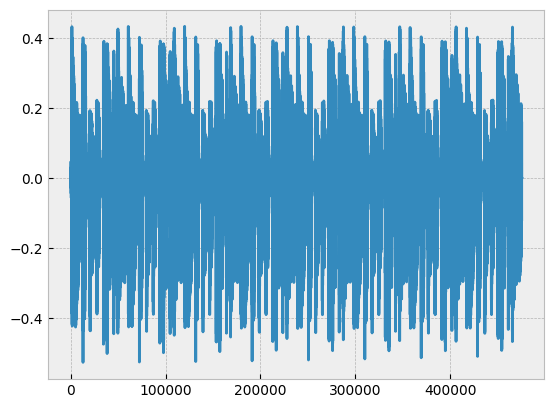

In [7]:
# Optional plot guitar
plt.plot(test_audio_guitar)
plt.show()
Audio(data=test_audio_guitar, rate=sr_guitar)


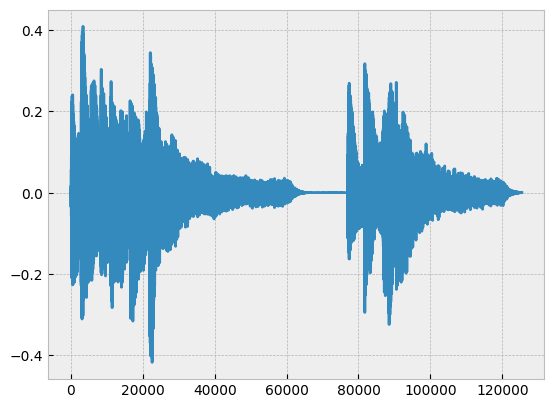

In [8]:
# Optional plot piano
plt.plot(test_audio_piano)
plt.show()
Audio(data=test_audio_piano, rate=sr_piano)

Should be A minor:

In [9]:
key_guit, maj_guit, min_guit = KS(test_audio_guitar, sr_guitar, coef = True, prof = "s")
print(f"Predicted keys: {key_guit[0]} and {key_guit[1]}\n Corr maj: {maj_guit:.2f}\n Corr min: {min_guit:.2f}")

if maj_guit > min_guit:
    print(f"Highest correlation: {key_guit[0]}: {maj_guit:.2f}")
else:
    print(f"Highest correlation: {key_guit[1]}: {min_guit:.2f}")

Predicted keys: G major and A minor
 Corr maj: 0.73
 Corr min: 0.90
Highest correlation: A minor: 0.90


Should be D major:

In [10]:
key_piano, maj_piano, min_piano = KS(test_audio_piano, sr_piano, coef = True, prof = "s")
print(f"Predicted keys: {key_piano[0]} and {key_piano[1]}\n Corr maj: {maj_piano:.2f}\n Corr min: {min_piano:.2f}")


if maj_piano > min_piano:
    print(f"Highest correlation: {key_piano[0]}: {maj_piano:.2f}")
else:
    print(f"Highest correlation: {key_piano[1]}: {min_piano:.2f}")

Predicted keys: G major and D minor
 Corr maj: 0.71
 Corr min: 0.99
Highest correlation: D minor: 0.99


> Note: As you can see, the piano sample's key estimation is wrong. The algorithm is not perfect. Hence let's see more rigorous testing :)

### 3.1 Testing and validation: KS

Let's remind first that our program's goal is to analyse an audio recording, for that we need wav's and mp3's. That's why we will use the Musicnet dataset for testing. More info about it [here](https://www.kaggle.com/datasets/imsparsh/musicnet-dataset?select=musicnet_metadata.csv). 

<span style="color:red">**Test results and graphs will be saved for ease of validation in `../test_results`!**</span>

The data is stored in .wav files in `/test_data` (250mb) and `/train_data`(20gb). In the leading examples I will use the data in `/train_data`.

> Due to the nature of audio processing, files are really large. If we compress 10 .wav files into an archive, it will be of size 80mbs (I have checked). So for if one wants to reproduce the testing data [here](https://www.kaggle.com/datasets/imsparsh/musicnet-dataset?select=musicnet_metadata.csv) is the link.

Along with the audio files we have .csv file `musicnet_metadata.csv` which we will use in the testing. 



Assuming we have downloaded the dataset in ``../musicnet``:
 

In [11]:
df = pd.read_csv("../musicnet/musicnet_metadata.csv")
df.head()

id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   
3  1730  Schubert  Piano Quintet in A major          5. Allegro giusto   
4  1733  Schubert   Piano Sonata in A major               2. Andantino   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
3  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
4     Solo Piano          Museopen                Segundo G. Yogore   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444  
3        OP114      368  
4         D959      546

A lot of information is of no use. We only want the key of the song which is in the `composition` column.

In [12]:
df = df[["id", "composition"]]
df.head()

id               composition
0  1727  Piano Quintet in A major
1  1728  Piano Quintet in A major
2  1729  Piano Quintet in A major
3  1730  Piano Quintet in A major
4  1733   Piano Sonata in A major

Now we will format second column to have only the tonic name ("A major" as an example).

In [13]:
# Function to extract everything after "in"
def extract_after_in(composition):
    return composition.split(" in ")[-1] if " in " in composition else composition
# Apply the function to the "composition" column
df["composition"]= df["composition"].apply(extract_after_in)
df.head(2)

id composition
0  1727     A major
1  1728     A major

Let's see what we have in it.

In [14]:
df["composition"].unique()

array(['A major', 'B-flat major', 'C major', 'A minor', 'C minor',
       '4 Impromptus', 'D-flat major', 'D major', 'G major',
       'E-flat major', 'D minor', 'E major', 'F major', 'B-flat Major',
       'D Minor', 'F Major', 'E minor', 'F minor', 'D Major', 'G minor',
       'F', 'F-sharp major', 'C-sharp major', 'B-flat minor',
       'C-sharp minor', 'Cello Suite 3', 'B major', 'A-flat major',
       'B minor', 'Cello Suite 4', 'E-flat minor', 'F-sharp minor',
       'G-sharp minor', 'E-flat major for Winds'], dtype=object)

Some str's weren't formatted properly. Some major keys start with a capital M. Let's fix that.

In [15]:
df['composition'] = df['composition'].str.replace('M', 'm')
print(df["composition"].unique())
df.head(10)

['A major' 'B-flat major' 'C major' 'A minor' 'C minor' '4 Impromptus'
 'D-flat major' 'D major' 'G major' 'E-flat major' 'D minor' 'E major'
 'F major' 'E minor' 'F minor' 'G minor' 'F' 'F-sharp major'
 'C-sharp major' 'B-flat minor' 'C-sharp minor' 'Cello Suite 3' 'B major'
 'A-flat major' 'B minor' 'Cello Suite 4' 'E-flat minor' 'F-sharp minor'
 'G-sharp minor' 'E-flat major for Winds']


id   composition
0  1727       A major
1  1728       A major
2  1729       A major
3  1730       A major
4  1733       A major
5  1734       A major
6  1735       A major
7  1739  B-flat major
8  1742       C major
9  1749       A minor

Now we will create a testing function which accepts the audio files and a separate list containing the actual keys. It is of great use to know that the files in `../misicnet/train_data` (or `/test_data`) have the same names as their IDs from the .csv file. We will use that. 

Let's first create a list of the file paths to the audio files and the keys list. Then we will create a function called `calculate_data` which accepts these files.

> Note: The monstrosity you are about to see in the second for loop of the function is there to account for the double names of accidentals. For example Bb is the same note as A#. Without this segment we will have quite a few false negatives. A smarter solution can be thought up, but not at the moment.

In [16]:
list_of_wavs = df["id"].apply(lambda x: "../musicnet/train_data/" + str(x) + ".wav")

# Cast as numpy arrays
list_of_wavs = list_of_wavs.to_numpy()
list_of_keys = df["composition"].to_numpy()
list_of_wavs[:3], list_of_keys[:3]

(array(['../musicnet/train_data/1727.wav',
        '../musicnet/train_data/1728.wav',
        '../musicnet/train_data/1729.wav'], dtype=object),
 array(['A major', 'A major', 'A major'], dtype=object))

In [17]:
def calculate_data(files, keys , n = 10, duration = 10, prof = None):
    '''
    Test accuracy of KS.

    Parameters
    ----------
    files : list of paths to .wav or .mp3 files
    keys : list of the actual keys where an entry corresponds to the name of the file
    n : number of files to analyse. Default is 10 but `train_data` has 330 entries
    prof : the pitch class profile

    Returns
    ----------
    pred : list of predicted keys
    actual : list of actual keys
    [accuracy , (count_true, count_false)] : accuracy calculated as the sum of correct and false predictions. Also their
                                             separate values.
    prof : profiles for KS()
    '''
    # Store output of calculate_corr
    pred = []
    actual = []

    # Predict key of every audio file in `files`
    for file, key_actual in zip(files[:n], keys[:n]):
        y, sr = lb.load(file, duration = duration)
        y, _ = lb.effects.trim(y, top_db=57)

        predicted_key = KS(y = y, sr = sr, prof = prof)

        # Store output
     
        pred.append(predicted_key)
        actual.append(key_actual)
        # pred.append((predicted_key, key_actual))

    # Simple count method where if predicted key == actual key > `count_true` +1
    count_true = 0
    count_false= 0

    for test, act in zip(pred, actual):

        # This ugly mess is to account for the different name sharing of 
        # accidentals. For example Bb is the same note as A#.
        # Note implementing this will result in false negatives!
        # There is probably a better way for doing this but for now this will work.
        # https://www.piano-keyboard-guide.com/music-note-names.html

        if test == act:
            count_true += 1
        else:
            if test == "B-flat major" or test == "A-sharp major":
                count_true += 1
            elif test == "B-flat minor" or test == "A-sharp minor":
                count_true += 1

            elif test == "C-sharp major" or test == "D-flat major":
                count_true += 1
            elif test == "C-sharp minor" or test == "D-flat minor":
                count_true += 1

            elif test == "E-flat major" or test == "D-sharp major":
                count_true += 1    
            elif test == "E-flat minor" or test == "D-sharp minor":
                count_true += 1  

            elif test == "G-flat major" or test == "F-sharp major":
                count_true += 1    
            elif test == "G-flat minor" or test == "F-sharp minor":
                count_true += 1  

            elif test == "A-flat major" or test == "G-sharp major":
                count_true += 1    
            elif test == "A-flat minor" or test == "G-sharp minor":
                count_true += 1  
                
            else:
                count_false += 1

    accuracy = np.round(count_true / np.sum([count_true, count_false]), 2)

    return pred, actual, [accuracy , (count_true, count_false)]        

In [18]:
# With n = 50 and duration of every audio file = 60 > average time to compute: 45s
# With n = 330 (max) and duration of every audio file = 60 > average time to compute: 5m 10s
n = 10
duration = 10
profiles = 't'
predicted, actual, accuracy = calculate_data(list_of_wavs, list_of_keys, n = n, duration = duration, prof = profiles)

Let's see the results:

Accuracy: 70.00%


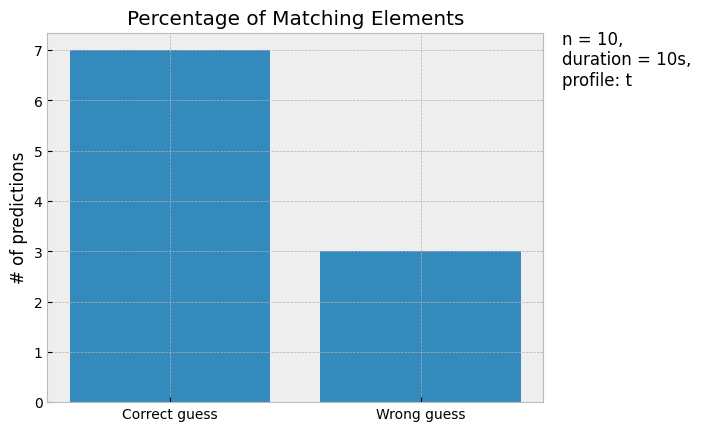

In [19]:
# Create a bar plot
labels = ["Correct guess", "Wrong guess"]
values = [accuracy[1][0], accuracy[1][1]]

print(f"Accuracy: {accuracy[0] * 100:.2f}%")
plt.bar(labels, values)
plt.title(f'Percentage of Matching Elements')
plt.ylabel('# of predictions')

text = f'n = {n},\nduration = {duration}s,\nprofile: {profiles}'
plt.text(0.93, 0.77, text, fontsize=12, transform=plt.gcf().transFigure)
plt.show()

Saved graph:

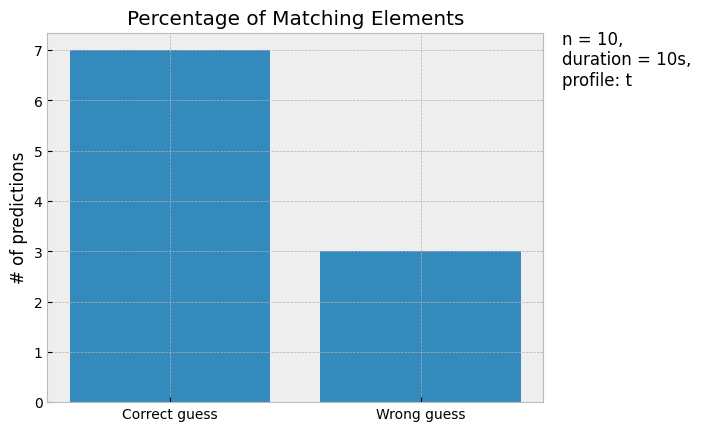

We can see that from 10 audio recordings, 6 predictions are correct. This is fine since the audio we are testing it on is **way** more complex in terms of composition (multiple instruments of example). In real world cases the program's intention will be to analyze single instrument recordings.

Nevertheless let's test it using a grid search. I have already precomputed the results, since it takes about 16 minutes for the code I have written below. Feel free to reproduce it.

In [20]:
# # Grid Search Code

# trials = [25, 50, 75, 100]
# time = [20, 60]
# time_list = []
# trials_list = []
# accuracy_list = []

# for num in trials:
#     for t in time:
#         # With n = 50 and duration of every audio file = 60 > average time to compute: 45s
#         # With n = 330 (max) and duration of every audio file = 60 > average time to compute: 5m 10s

#         predicted, actual, accuracy = calculate_data(list_of_wavs, list_of_keys, n = num, duration = t)

#         time_list.append(t)
#         trials_list.append(num)
#         accuracy_list.append([accuracy, [t, num]])


The results are in `../test_results/csv/grid_search_test.csv`. Let's open it

In [21]:
test_data = pd.read_csv("../test_results/csv/grid_search_test.csv")
test_data

Unnamed: 0  Accuracy  Duration  N_files
0            0      0.64        20       25
1            1      0.64        60       25
2            2      0.60        20       50
3            3      0.56        60       50
4            4      0.64        20       75
5            5      0.61        60       75
6            6      0.64        20      100
7            7      0.65        60      100
8            8      0.66        20      125
9            9      0.67        60      125
10          10      0.65        20      150
11          11      0.68        60      150
12          12      0.66        20      330
13          13      0.65        60      330

We want to see how much is the accuracy and does it change somehow. To do that we will put all the columns in separate variables, calculate the accuracy mean and plot a graph for visualization.

In [22]:
acc = test_data.Accuracy
dur = test_data.Duration
nf = test_data.N_files

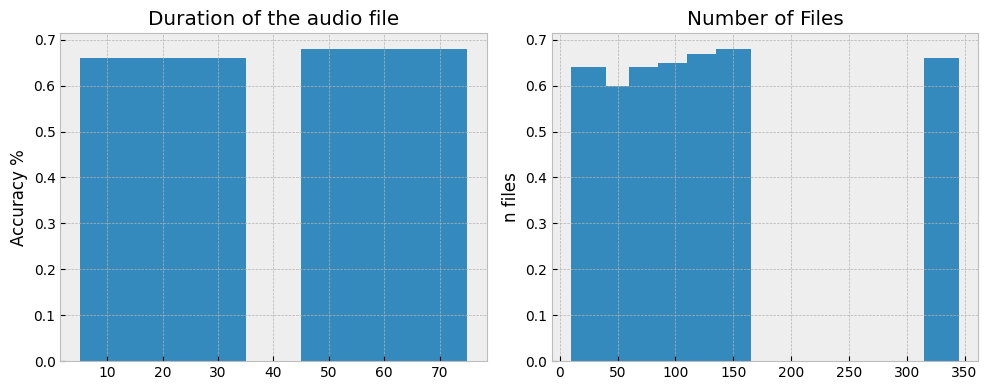

In [23]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Duration vs Accuracy
axs[0].bar(dur, acc, width=30)
axs[0].set_ylabel('Accuracy %')
axs[0].set_title('Duration of the audio file')

# Plot 2: Number of Files vs Accuracy
axs[1].bar(nf, acc, width=30)
axs[1].set_ylabel('n files')
axs[1].set_title('Number of Files')

# Adjust layout to avoid overlapping labels
plt.tight_layout()

plt.show()

In [24]:
np.mean(acc)

0.6392857142857143

Saved graph:

<!-- ![alt text](../test_results/graphs/p_match_el1.png) -->

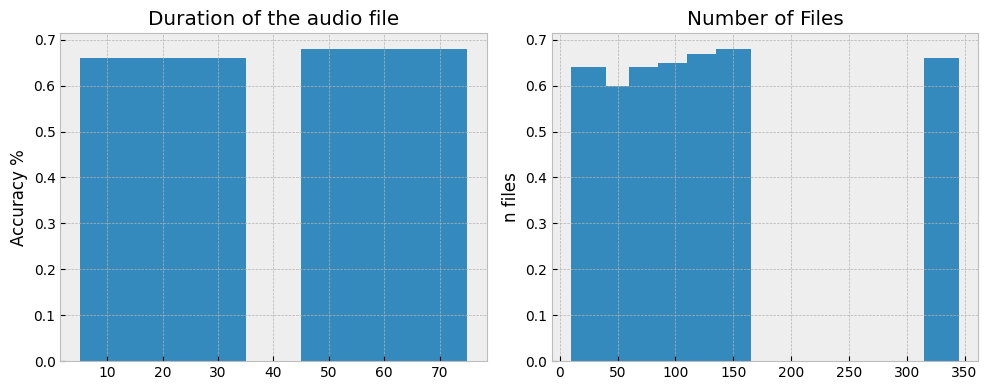

We got a mean value of around `0.64`. This finding doesn't deviate from other studies on this topic. [This](https://www.researchgate.net/publication/253466703_Key-finding_with_interval_profiles) one by Søren Tjagvad Madsen and Gerhard Widmer published in 2007 show the accuracy of this method to also hover around 60%.
 
It is also important to note that the pitch profiles used in `calculate_corr` (s, ks, b, ae, t) should change the accuracy, with `s` being the most consistent according to [Standford's Humdrum docs](https://extras.humdrum.org/man/keycor/). Let's test that.

We will run another grid search loop to see the accuracy of all the profiles for 10, 50, 100 and 200 files. The precomputed result is saved `grid_search_multi_profile.csv`. Time to calculate ~ 12 minutes if one wants to reproduce it.

In [25]:
# # Grid Search Code II

# trials = [10, 50, 100, 200]
# profile_list = ["s", "ks", "b", "ae", "t"]

# accuracy_list = []

# for p in profile_list:
#     for num in trials:
#         # With n = 50 and duration of every audio file = 60 > average time to compute: 45s
#         # With n = 330 (max) and duration of every audio file = 60 > average time to compute: 5m 10s

#         predicted, actual, accuracy = calculate_data(list_of_wavs, list_of_keys, n = num, duration = 20, prof = p)

#         accuracy_list.append([accuracy, [p, num]])

# accuracy_vals = [item[0][0] for item in accuracy_list]
# profile_names = [item[1][0] for item in accuracy_list]
# n_vals = [item[1][1] for item in accuracy_list]

# gr_s = pd.DataFrame({"accuracy" : accuracy_vals, "profile" : profile_names, "trials" : n_vals})
# gr_s.to_csv("grid_search_multi_profile.csv")
# gr_s.head

In [26]:
grid_search_profile_data = pd.read_csv("../test_results/csv/grid_search_multi_profile.csv",
                                        usecols = [1, 2, 3])
grid_search_profile_data

accuracy profile  trials
0       0.60       s      10
1       0.52       s      50
2       0.62       s     100
3       0.64       s     200
4       0.50      ks      10
5       0.50      ks      50
6       0.54      ks     100
7       0.59      ks     200
8       0.70       b      10
9       0.60       b      50
10      0.64       b     100
11      0.68       b     200
12      0.60      ae      10
13      0.60      ae      50
14      0.65      ae     100
15      0.68      ae     200
16      0.70       t      10
17      0.56       t      50
18      0.64       t     100
19      0.70       t     200

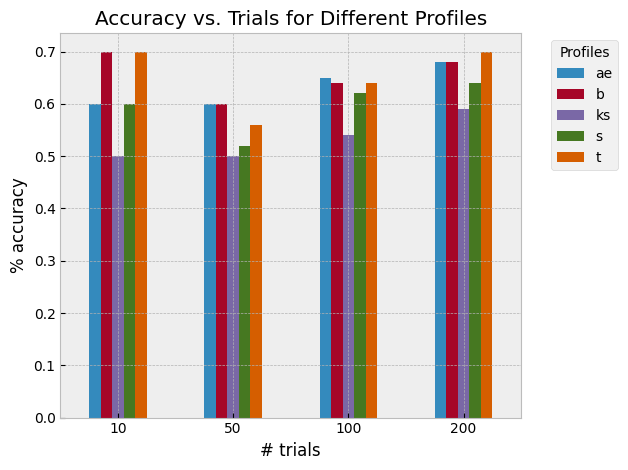

In [27]:
# Create a pivot table to rearrange the data for plotting
pivot_data = grid_search_profile_data.pivot(index='trials', columns='profile', values='accuracy')

# Create a bar plot
ax = pivot_data.plot(kind='bar', rot=0)

plt.xlabel('# trials')
plt.ylabel('% accuracy')
plt.title('Accuracy vs. Trials for Different Profiles')

# Move the legend outside the plot
ax.legend(title='Profiles', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.tight_layout()
plt.show()

Saved graph:

<!-- ![alt text](../test_results/graphs/profile_graph.png) -->

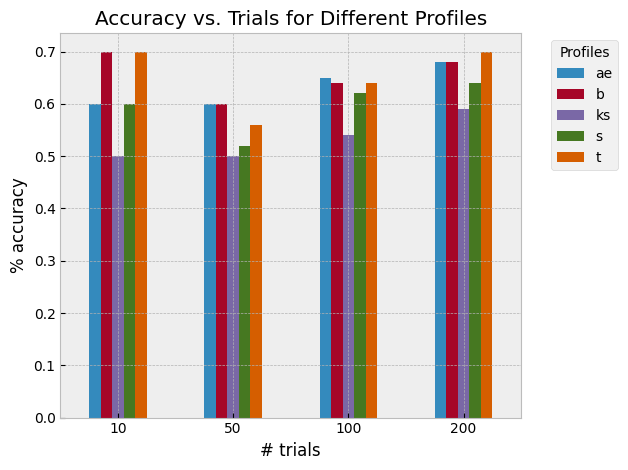


We see that except for n = 50, `s` is more consistent. That is if we don't calculate it and just use our eyes. But I have also taken the time to calculate it! Let's see:

We want to check which profile is the most consistent. To do that we will calculate the mean of the `accuracy` column and then calculate the `standard deviation`. We are doing this to see how much the profiles deviate from the *norm* (mean).

In [28]:
# Calculate the mean accuracy for each profile and trial combination
# grouped = grid_search_profile_data.groupby(['profile', 'trials'])['accuracy']
grouped = grid_search_profile_data.copy()
grouped["accuracy_mean_global"] = grouped["accuracy"].mean()

# Merge the mean accuracy back into the original DataFrame
grid_search_profile_data = grid_search_profile_data.merge(grouped)

# # Calculate the absolute deviation from the mean accuracy
grid_search_profile_data['deviation'] = grid_search_profile_data['accuracy'] - grid_search_profile_data['accuracy_mean_global']
grid_search_profile_data['abs_deviation'] = grid_search_profile_data['deviation'].abs()

# # Calculate the mean absolute deviation for each profile
profile_mean_deviation = grid_search_profile_data.groupby('profile')['abs_deviation'].mean()

# # Find the profile with the smallest mean absolute deviation
profile_with_smallest_deviation = profile_mean_deviation.idxmin()

print(f"The profile with the smallest mean absolute deviation is: {profile_with_smallest_deviation}")
grid_search_profile_data

The profile with the smallest mean absolute deviation is: ae


accuracy profile  trials  accuracy_mean_global  deviation  abs_deviation
0       0.60       s      10                 0.613     -0.013          0.013
1       0.52       s      50                 0.613     -0.093          0.093
2       0.62       s     100                 0.613      0.007          0.007
3       0.64       s     200                 0.613      0.027          0.027
4       0.50      ks      10                 0.613     -0.113          0.113
5       0.50      ks      50                 0.613     -0.113          0.113
6       0.54      ks     100                 0.613     -0.073          0.073
7       0.59      ks     200                 0.613     -0.023          0.023
8       0.70       b      10                 0.613      0.087          0.087
9       0.60       b      50                 0.613     -0.013          0.013
10      0.64       b     100                 0.613      0.027          0.027
11      0.68       b     200                 0.613      0.067          0.067
12      0.60      ae      10                 0.613     -0.013          0.013
13      0.60      ae      50                 0.613     -0.013          0.013
14      0.65      ae     100                 0.613      0.037          0.037
15      0.68      ae     200                 0.613      0.067          0.067
16      0.70       t      10                 0.613      0.087          0.087
17      0.56       t      50                 0.613     -0.053          0.053
18      0.64       t     100                 0.613      0.027          0.027
19      0.70       t     200                 0.613      0.087          0.087

*Hmmmm...*

This is not what we expected from the information given in the [Humdrum docs](https://extras.humdrum.org/man/keycor/)! We got that the most consistent profile is `ae`. This result doesn't mean that `ae` is the most consistent since we have limited data and don't know the method of calculating the consistency of the profiles used in the humdrum.org's doc. Nevertheless it was interesting to see that `ae` came out on top.

Now  the accuracy can be better but we have to keep in mind that the given audio samples are complex compositions with multiple instruments playing at the same time. Simpler compositions tend to be easier to detect. Quick example:

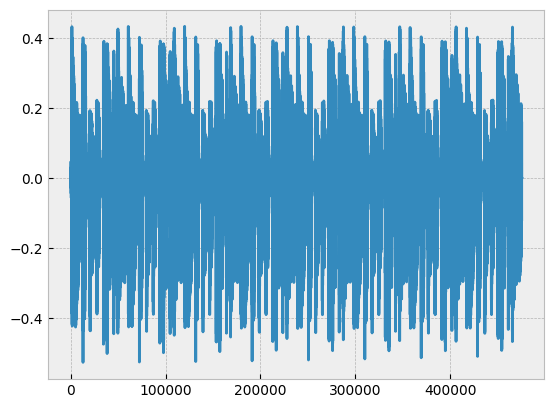

A minor


In [29]:
example_guitar, sr_example = lb.load("../audio/testing/Amin_u_guitar.wav")
example_guitar, _ = lb.effects.trim(example_guitar, top_db=57)
plt.plot(example_guitar)
plt.show()

# example_ks = KS(example_guitar, sr_example, True)
example_ks = KS(example_guitar, sr_example)

print(example_ks)

Audio(data=example_guitar, rate=sr_example)


### 4. Pitch estimation using pYin

The name the algorithm comes from the term "yin and yang"[<sup>\[4\]</sup>](#fn4). The way it works is by calculating the similarity between a given audio signal and it's shifted copy. [This video](https://www.youtube.com/watch?v=W585xR3bjLM) by *V For Science* does a really good job of explaining the inner workings of the algorithm.
 
<!-- <div style="text-align:center">

![alt text](../media/signals1.jpg)</div> -->

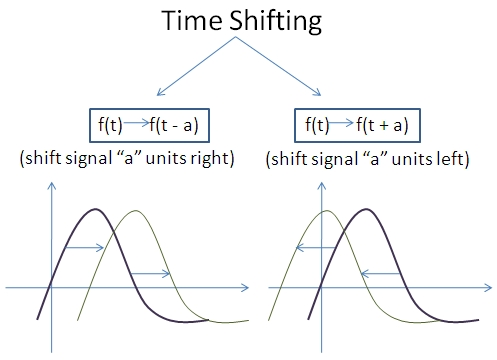

Fortunately librosa has a build-in implementation: `librosa.pyin()`. I have done just a few minor adjustments: 

`easy_pyin` - takes only an audio sample and its sample rate. The hyperparameters are already set and no tinkering is required, hence the name.

`easy_plot` - plots the detected notes of the given audio. It also prints the note names if `print_notes = True`.


In [30]:
def easy_pyin(audio, sr):
    '''
    A helper function designed for easier utilization of the pYIN algorithm for pitch estimation.

    Parameters
    ----------
    audio : numpy array
        The audio time series data.
    sr : int
        The sampling rate of the audio.

    Returns
    -------
    f0_filtered : numpy array
        An array containing the estimated fundamental frequencies (F0) of voiced segments, after filtering out zero Hz values.
    voiced_flag : numpy array
        An array indicating whether a frame is voiced (1) or unvoiced (0).
    voiced_probs : numpy array
        An array containing the probability of each frame being voiced.

    Notes
    -----
     This function utilizes the pYIN algorithm to estimate pitch (fundamental frequency) and process the results.

    The input audio time series should be provided in the form of a numpy array.

    pYIN is a pitch detection algorithm used for estimating the pitch of audio signals.

    The returned `f0_filtered` array contains the estimated F0 values after removing zero Hz points.

    `voiced_flag` and `voiced_probs` provide information about the voiced/unvoiced status of each 
    
    frame along with associated probabilities.
    '''
    f0, voiced_flag, voiced_probs = lb.pyin(audio,
                                            sr = sr,
                                            fmin=lb.note_to_hz('C2'),
                                            fmax=lb.note_to_hz('C7'),
                                            frame_length = 2048*4, # 2048, 4096, 6144, 8192                                       
                                            resolution = 1,
                                            fill_na=0)
                            
    # Filter zero Hz points
    f0_filtered = f0[f0 != 0]
    
    index = np.where(f0[f0 != 0])[0]
    voiced_flag = voiced_flag[index]
    voiced_probs = voiced_probs[index]    

    return f0_filtered, voiced_flag, voiced_probs

In [31]:
def easy_plot(audio_file, sr, actual_n = None, title = "", p = 0, print_notes = False):
    '''
    A utility function for simplified plotting and analysis of pitch estimation results.

    Parameters
    ----------
    audio_file : numpy array
        The audio time series data.
    sr : int
        The sampling rate of the audio.
    actual_n : list of str
        A list containing the actual notes corresponding to the audio.
    title : str, optional
        The title of the plot, by default an empty string.
    p : float, optional
        The probability threshold for considering high-confidence F0 values, by default None.

    Returns
    -------
    high_prob_f0 : list
        A list of high-confidence fundamental frequencies (F0) if `p` is provided.

    Notes
    -----
    This function utilizes the `easy_pyin` function for pitch estimation and performs additional analysis.

    The function calculates F0 values using the pYIN algorithm and plots them over time.

    If a probability threshold `p` is provided, the function filters F0 values with probabilities above the threshold and returns them in `high_prob_f0`.

    The function also calculates and prints the elapsed time for F0 calculation, detected notes, accuracy of detected notes compared to `actual_n`, and the total F0 count.

    You can provide the `title` parameter to customize the title of the plot.
    '''
    def calculate_accuracy(list1, list2):
        '''
        Calculate the accuracy of two lists by comparing their common elements.

        Parameters
        ----------
        list1 : list
            The first list of elements.
        list2 : list
            The second list of elements.

        Returns
        -------
        accuracy : float
            The accuracy, expressed as the ratio of common elements to the maximum length of the two lists.

        Notes
        -----
        This function calculates the accuracy by finding the common elements between the two lists
        and dividing the count of common elements by the maximum length of the two lists.
        '''
        common_strings = set(list1) & set(list2)
        accuracy = len(common_strings) / max(len(list1), len(list2))
        return accuracy


    def filter_repeating_elements(input_list):
        '''
        Filter out repeated elements in a list, retaining only non-consecutive duplicates.

        Parameters
        ----------
        input_list : list
            The input list of elements.

        Returns
        -------
        filtered_list : list
            A list with repeating elements filtered, keeping only non-consecutive duplicates.

        Notes
        -----
        This function processes the input list and removes consecutive duplicate elements.
        It retains only non-consecutive duplicates, ensuring that each element is present at most once consecutively.
        '''
        filtered_list = []
        last_element = None
        repetition_count = 0

        for element in input_list:
            if element == last_element:
                repetition_count += 1
            else:
                repetition_count = 1

            if repetition_count <= 1:
                filtered_list.append(element)

            last_element = element

        return filtered_list

    # Get f0
    f0, voiced_flag, voiced_probs = easy_pyin(audio_file, sr)
    times = lb.times_like(f0)


    # Count of f0
    count = 0
    for prob in voiced_probs:
        if prob >= p:
            count += 1
    print(f"F0 count: {count}")

    if print_notes:

        unique, counts  = np.unique(f0, return_counts = True)
        repeating_indexes = np.where(counts > 1)

        times_higher_than_1 = times[repeating_indexes]
        f0_higher_than_1 = unique[repeating_indexes]

        note_symbolic = np.array([lb.hz_to_note(f0_higher_than_1)])
        print(filter_repeating_elements(note_symbolic[0]))
    
    # Print accuracy
    if actual_n is not None:
        accuracy = calculate_accuracy(f_notes, actual_n)
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Notes actual")
        print(actual_n)

    # Plot graph
    fig, axes = plt.subplots(figsize=[4, 4])
    axes.scatter(times, f0, marker="o", s=5)
    axes.set_xlabel("Time")
    axes.set_ylabel("Hz")
    
    if title == "":
        axes.set_title(f"f0")
    else:
        axes.set_title(title)

    plt.show()   

Now we shall load an audio example and see what we can do with it.

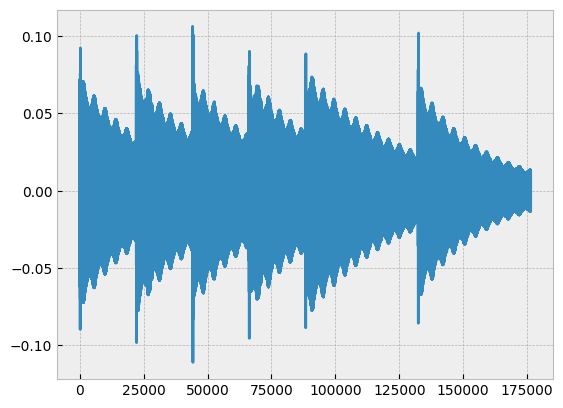

A minor


In [32]:
example_audio_pyin, sr_example = lb.load("../audio/testing/u_cbcbad_piano.wav")
example_audio_pyin, _ = lb.effects.trim(example_audio_pyin, top_db=57)

plt.plot(example_audio_pyin)
plt.show()

example_ks = KS(example_audio_pyin, sr_example)
print(example_ks)
Audio(data=example_audio_pyin, rate=sr_example)


Let's plot it:

F0 count: 86
['A4', 'B4', 'C5', 'D5']


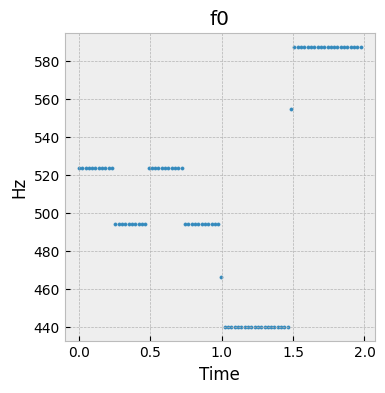

In [33]:
easy_plot(example_audio_pyin, sr_example, print_notes = True)

The played notes are A, B, C and D, which are the correct ones.

Another thing one can do but it's really hard is to convert the sound from audio to midi. There are many off the shelf programs, including one library which we can use!

The library is called `audio_to_midi` ([github](https://github.com/tiagoft/audio_to_midi)), created by [tiagoft](https://github.com/tiagoft). I have tried installing it with `pip` but for some reason it does not work, but we can copy the code from the repo since there are only 5 main functions we can use.

>Now I really want to emphasize - this was not my code. While researching how to do audio to midi conversion I saw this open source library and wanted to try it. When I couldn't install it I tried copying the code to see if it works. I am adding this to show how the final program, if ever finished, will look and feel. In the future if I really continue with this project I will create a custom implementation. Also it is cool to see how something you have played with a guitar IRL gets converted to MIDI and you can, say, play the same thing but with a saxophone instead :D !

In [34]:
# Audio to Midi --- Code by tiagoft

import librosa

def transition_matrix(
        note_min: str,
        note_max: str,
        p_stay_note: float,
        p_stay_silence: float) -> np.array:
    """
    Returns the transition matrix with one silence state and two states
    (onset and sustain) for each note. This matrix mixes an acoustic model with two states with
    an uniform-transition linguistic model.

    Parameters
    ----------
    note_min : string, 'A#4' format
        Lowest note supported by this transition matrix
    note_max : string, 'A#4' format
        Highest note supported by this transition matrix
    p_stay_note : float, between 0 and 1
        Probability of a sustain state returning to itself.
    p_stay_silence : float, between 0 and 1
        Probability of the silence state returning to itselt.

    Returns
    -------
    transmat : np.array (2*N_notes+1x2*N_notes+1)
        Trasition matrix in which t[i,j] is the probability of
        going from state i to state j

    """

    midi_min = librosa.note_to_midi(note_min)
    midi_max = librosa.note_to_midi(note_max)
    n_notes = midi_max - midi_min + 1
    p_l = (1 - p_stay_silence) / n_notes
    p_ll = (1 - p_stay_note) / (n_notes + 1)

    # Transition matrix:
    # State 0 = silence
    # States 1, 3, 5... = onsets
    # States 2, 4, 6... = sustains
    transmat = np.zeros((2 * n_notes + 1, 2 * n_notes + 1))

    # State 0: silence
    transmat[0, 0] = p_stay_silence
    for i in range(n_notes):
        transmat[0, (i * 2) + 1] = p_l

    # States 1, 3, 5... = onsets
    for i in range(n_notes):
        transmat[(i * 2) + 1, (i * 2) + 2] = 1

    # States 2, 4, 6... = sustains
    for i in range(n_notes):
        transmat[(i * 2) + 2, 0] = p_ll
        transmat[(i * 2) + 2, (i * 2) + 2] = p_stay_note
        for j in range(n_notes):
            transmat[(i * 2) + 2, (j * 2) + 1] = p_ll

    return transmat


def prior_probabilities(
        audio_signal: np.array,
        note_min: str,
        note_max: str,
        srate: int,
        frame_length: int = 2048,
        hop_length: int = 512,
        pitch_acc: float = 0.9,
        voiced_acc: float = 0.9,
        onset_acc: float = 0.9,
        spread: float = 0.2) -> np.array:
    """
    Estimate prior (observed) probabilities from audio signal

    Parameters
    ----------
    audio_signal : 1-D numpy array
        Array containing audio samples

    note_min : string, 'A#4' format
        Lowest note supported by this estimator
    note_max : string, 'A#4' format
        Highest note supported by this estimator
    srate : int
        Sample rate.
    frame_length : int
    window_length : int
    hop_length : int
        Parameters for FFT estimation
    pitch_acc : float, between 0 and 1
        Probability (estimated) that the pitch estimator is correct.
    voiced_acc : float, between 0 and 1
        Estimated accuracy of the "voiced" parameter.
    onset_acc : float, between 0 and 1
        Estimated accuracy of the onset detector.
    spread : float, between 0 and 1
        Probability that the singer/musician had a one-semitone deviation
        due to vibrato or glissando.

    Returns
    -------
    priors : 2D numpy array.
        priors[j,t] is the prior probability of being in state j at time t.

    """

    fmin = librosa.note_to_hz(note_min)
    fmax = librosa.note_to_hz(note_max)
    midi_min = librosa.note_to_midi(note_min)
    midi_max = librosa.note_to_midi(note_max)
    n_notes = midi_max - midi_min + 1

    # pitch and voicing
    pitch, voiced_flag, _ = librosa.pyin(
        y=audio_signal, fmin=fmin * 0.9, fmax=fmax * 1.1,
        sr=srate, frame_length=frame_length, win_length=int(frame_length / 2),
        hop_length=hop_length)
    tuning = librosa.pitch_tuning(pitch)
    f0_ = np.round(librosa.hz_to_midi(pitch - tuning)).astype(int)
    onsets = librosa.onset.onset_detect(
        y=audio_signal, sr=srate,
        hop_length=hop_length, backtrack=True)

    priors = np.ones((n_notes * 2 + 1, len(pitch)))

    for n_frame in range(len(pitch)):
        # probability of silence or onset = 1-voiced_prob
        # Probability of a note = voiced_prob * (pitch_acc) (estimated note)
        # Probability of a note = voiced_prob * (1-pitch_acc) (estimated note)
        if not voiced_flag[n_frame]:
            priors[0, n_frame] = voiced_acc
        else:
            priors[0, n_frame] = 1 - voiced_acc

        for j in range(n_notes):
            if n_frame in onsets:
                priors[(j * 2) + 1, n_frame] = onset_acc
            else:
                priors[(j * 2) + 1, n_frame] = 1 - onset_acc

            if j + midi_min == f0_[n_frame]:
                priors[(j * 2) + 2, n_frame] = pitch_acc

            elif np.abs(j + midi_min - f0_[n_frame]) == 1:
                priors[(j * 2) + 2, n_frame] = pitch_acc * spread

            else:
                priors[(j * 2) + 2, n_frame] = 1 - pitch_acc

    return priors


def states_to_pianoroll(states: list, note_min: str, hop_time: float) -> list:
    """
    Converts state sequence to an intermediate, internal piano-roll notation

    Parameters
    ----------
    states : list of int (or other iterable)
        Sequence of states estimated by Viterbi
    note_min : string, 'A#4' format
        Lowest note supported by this estimator
    hop_time : float
        Time interval between two states.

    Returns
    -------
    output : List of lists
        output[i] is the i-th note in the sequence. Each note is a list
        described by [onset_time, offset_time, pitch, note_name], e.g., output[1][0]
        is the onset time for the second note.
    """
    midi_min = librosa.note_to_midi(note_min)

    states_ = np.hstack((states, np.zeros(1)))

    # possible types of states
    silence = 0
    onset = 1
    sustain = 2

    my_state = silence
    output = []

    last_onset = 0
    last_offset = 0
    last_midi = 0
    for i, _ in enumerate(states_):
        if my_state == silence:
            if int(states_[i] % 2) != 0:
                # Found an onset!
                last_onset = i * hop_time
                last_midi = ((states_[i] - 1) / 2) + midi_min
                last_note = librosa.midi_to_note(last_midi)
                my_state = onset

        elif my_state == onset:
            if int(states_[i] % 2) == 0:
                my_state = sustain

        elif my_state == sustain:
            if int(states_[i] % 2) != 0:
                # Found an onset.
                # Finish last note
                last_offset = i * hop_time
                my_note = [last_onset, last_offset, last_midi, last_note]
                output.append(my_note)

                # Start new note
                last_onset = i * hop_time
                last_midi = ((states_[i] - 1) / 2) + midi_min
                last_note = librosa.midi_to_note(last_midi)
                my_state = onset

            elif states_[i] == 0:
                # Found silence. Finish last note.
                last_offset = i * hop_time
                my_note = [last_onset, last_offset, last_midi, last_note]
                output.append(my_note)
                my_state = silence

    return output


def pianoroll_to_midi(bpm: float, pianoroll: list) -> midiutil.MIDIFile():
    """
    Converts an internal piano roll notation to a MIDI file

    Parameters
    ----------
    bpm: float
        Beats per minute for the MIDI file. If necessary, use
        bpm = librosa.beat.tempo(y)[0] to estimate bpm.

    pianoroll : list
        A pianoroll list as estimated by states_to_pianoroll().

    Returns
    -------
    None.

    """
    quarter_note = 60 / bpm

    onsets = np.array([p[0] for p in pianoroll])
    offsets = np.array([p[1] for p in pianoroll])

    onsets = onsets / quarter_note
    offsets = offsets / quarter_note
    durations = offsets - onsets

    midi = midiutil.MIDIFile(1)
    midi.addTempo(0, 0, bpm)

    for i, _ in enumerate(onsets):
        midi.addNote(
            0, 0, int(pianoroll[i][2]), onsets[i], durations[i], 100)

    return midi


def wave_to_midi(
        audio_signal: np.array,
        srate: int = 22050,
        frame_length: int = 2048,
        hop_length: int = 512,
        note_min: str = "A2",
        note_max: str = "E5",
        p_stay_note: float = 0.9,
        p_stay_silence: float = 0.7,
        pitch_acc: float = 0.9,
        voiced_acc: float = 0.9,
        onset_acc: float = 0.9,
        spread: float = 0.2) -> midiutil.MIDIFile():
    """Converts an audio signal to a MIDI file

    Args:
        audio_signal (np.array): Array containing audio samples
        srate (int, optional): Sample rate of the audio signal Defaults to 22050.
        frame_length (int, optional): Frame length for analysis. Defaults to 2048.
        hop_length (int, optional): Hop between two frames in analysis. Defaults to 512.
        note_min (str, optional): Lowest allowed note in "A#4" format. Defaults to "A2".
        note_max (str, optional): Highest allowed note in "A#4" format. Defaults to "E5".
        p_stay_note (float, optional): Probability of staying in the same note for two
                                                 subsequent frames. Defaults to 0.9.
        p_stay_silence (float, optional): Probability of staying in the silence state for
                                                 two subsequent frames. Defaults to 0.7.
        pitch_acc (float, optional): Probability (reliability) that the pitch estimator
                                                 is correct. Defaults to 0.9.
        voiced_acc (float, optional): Estimated accuracy of the "voiced" parameter.
                                                 Defaults to 0.9.
        onset_acc (float, optional): Estimated accuracy of the onset detector. Defaults to 0.9.
        spread (float, optional): Probability that the audio signal deviates by one semitone
                                                 due to vibrato or glissando. Defaults to 0.2.

    Returns:
        midi (midiutil.MIDIFile): A MIDI file that can be written to disk.
    """
    transmat = transition_matrix(note_min, note_max, p_stay_note, p_stay_silence)
    priors = prior_probabilities(
        audio_signal,
        note_min,
        note_max,
        srate,
        frame_length,
        hop_length,
        pitch_acc,
        voiced_acc,
        onset_acc,
        spread)
    p_init = np.zeros(transmat.shape[0])
    p_init[0] = 1
    states = librosa.sequence.viterbi(priors, transmat, p_init=p_init)

    pianoroll = states_to_pianoroll(states, note_min, hop_length / srate)
    bpm = librosa.beat.tempo(y=audio_signal)[0]
    midi = pianoroll_to_midi(bpm, pianoroll)

    return midi

In [35]:
# Load the audio file
audio_file = "../audio/testing/Amin_acdega_guitar.wav"
audio, sr = librosa.load(audio_file)
Audio(data=audio, rate=sr)

Set hyperparameters:

In [36]:
# Set parameters
note_min = "A2"
note_max = "E5"
p_stay_note = 0.9
p_stay_silence = 0.7
pitch_acc = 0.9
voiced_acc = 0.9
onset_acc = 0.9
spread = 0.2

Call the function:

In [37]:
# Convert audio to MIDI
warnings.filterwarnings("ignore") # Ignore runtime warnings for depreciated functions. Comment this row if want to see them.
midi = wave_to_midi(
    audio_signal=audio,
    srate=sr,
    note_min=note_min,
    note_max=note_max,
    p_stay_note=p_stay_note,
    p_stay_silence=p_stay_silence,
    pitch_acc=pitch_acc,
    voiced_acc=voiced_acc,
    onset_acc=onset_acc,
    spread=spread
)
warnings.resetwarnings()

Save midi file so we can play it later:

In [38]:
# Save the MIDI file
output_midi_path = "../outputs/output.mid"
with open(output_midi_path, "wb") as output_file:
    midi.writeFile(output_file)

# Display a link to download the generated MIDI file
FileLink(output_midi_path)


e:\Adademics and Courses\SU\DS\Project_PDA\outputs\output.mid

It works!

If one wants to hear `/output.mid` you can just open it in windows media player on in your favorite DAW!

And with that we have somewhat of a working demo. For ease of use we can create a class and simply call it. We will name it MyMusicBuddy :D. You call the object to get only the key/note/midi or get everything.

In [39]:
class MyMusicBuddy:
    def __init__(self, audio_path, note_min="A2", note_max="E5"):
        self.audio_path = audio_path
        self.note_min = note_min
        self.note_max = note_max
    
    warnings.filterwarnings("ignore") # Ignore runtime warnings for depreciated functions. Comment this row if want to see them.

    def _transition_matrix(self, note_min, note_max, p_stay_note, p_stay_silence):
        # Implementation of transition_matrix function
            midi_min = lb.note_to_midi(note_min)
            midi_max = lb.note_to_midi(note_max)
            n_notes = midi_max - midi_min + 1
            p_l = (1 - p_stay_silence) / n_notes
            p_ll = (1 - p_stay_note) / (n_notes + 1)

            transmat = np.zeros((2 * n_notes + 1, 2 * n_notes + 1))

            transmat[0, 0] = p_stay_silence
            for i in range(n_notes):
                transmat[0, (i * 2) + 1] = p_l

            for i in range(n_notes):
                transmat[(i * 2) + 1, (i * 2) + 2] = 1

            for i in range(n_notes):
                transmat[(i * 2) + 2, 0] = p_ll
                transmat[(i * 2) + 2, (i * 2) + 2] = p_stay_note
                for j in range(n_notes):
                    transmat[(i * 2) + 2, (j * 2) + 1] = p_ll

            return transmat
    

    def _prior_probabilities(self, audio_signal, srate, frame_length, hop_length,
                             pitch_acc, voiced_acc, onset_acc, spread):
        # Implementation of prior_probabilities function
        fmin = lb.note_to_hz(self.note_min)
        fmax = lb.note_to_hz(self.note_max)
        midi_min = lb.note_to_midi(self.note_min)
        midi_max = lb.note_to_midi(self.note_max)
        n_notes = midi_max - midi_min + 1

        pitch, voiced_flag, _ = lb.pyin(
            y=audio_signal, fmin=fmin * 0.9, fmax=fmax * 1.1,
            sr=srate, frame_length=frame_length, win_length=int(frame_length / 2),
            hop_length=hop_length)
        tuning = lb.pitch_tuning(pitch)
        f0_ = np.round(lb.hz_to_midi(pitch - tuning)).astype(int)
        onsets = lb.onset.onset_detect(
            y=audio_signal, sr=srate,
            hop_length=hop_length, backtrack=True)

        priors = np.ones((n_notes * 2 + 1, len(pitch)))

        for n_frame in range(len(pitch)):
            if not voiced_flag[n_frame]:
                priors[0, n_frame] = voiced_acc
            else:
                priors[0, n_frame] = 1 - voiced_acc

            for j in range(n_notes):
                if n_frame in onsets:
                    priors[(j * 2) + 1, n_frame] = onset_acc
                else:
                    priors[(j * 2) + 1, n_frame] = 1 - onset_acc

                if j + midi_min == f0_[n_frame]:
                    priors[(j * 2) + 2, n_frame] = pitch_acc
                elif np.abs(j + midi_min - f0_[n_frame]) == 1:
                    priors[(j * 2) + 2, n_frame] = pitch_acc * spread
                else:
                    priors[(j * 2) + 2, n_frame] = 1 - pitch_acc

        return priors
    

    def _states_to_pianoroll(self, states, hop_time):
        # Implementation of states_to_pianoroll function
        midi_min = lb.note_to_midi(self.note_min)
        states_ = np.hstack((states, np.zeros(1)))

        silence = 0
        onset = 1
        sustain = 2

        my_state = silence
        output = []

        last_onset = 0
        last_offset = 0
        last_midi = 0

        for i, _ in enumerate(states_):
            if my_state == silence:
                if int(states_[i] % 2) != 0:
                    last_onset = i * hop_time
                    last_midi = ((states_[i] - 1) / 2) + midi_min
                    last_note = lb.midi_to_note(last_midi)
                    my_state = onset

            elif my_state == onset:
                if int(states_[i] % 2) == 0:
                    my_state = sustain

            elif my_state == sustain:
                if int(states_[i] % 2) != 0:
                    last_offset = i * hop_time
                    my_note = [last_onset, last_offset, last_midi, last_note]
                    output.append(my_note)

                    last_onset = i * hop_time
                    last_midi = ((states_[i] - 1) / 2) + midi_min
                    last_note = lb.midi_to_note(last_midi)
                    my_state = onset

                elif states_[i] == 0:
                    last_offset = i * hop_time
                    my_note = [last_onset, last_offset, last_midi, last_note]
                    output.append(my_note)
                    my_state = silence

        return output


    def _pianoroll_to_midi(self, bpm, pianoroll):
        # Implementation of pianoroll_to_midi function
        quarter_note = 60 / bpm

        onsets = np.array([p[0] for p in pianoroll])
        offsets = np.array([p[1] for p in pianoroll])

        onsets = onsets / quarter_note
        offsets = offsets / quarter_note
        durations = offsets - onsets

        midi = midiutil.MIDIFile(1)
        midi.addTempo(0, 0, bpm)

        for i, _ in enumerate(onsets):
            midi.addNote(
                0, 0, int(pianoroll[i][2]), onsets[i], durations[i], 100)

        return midi
    
    def wave_to_midi(self, audio_signal, srate=22050, frame_length=2048, hop_length=512,
                     note_min="A2", note_max="E5", p_stay_note=0.9, p_stay_silence=0.7,
                     pitch_acc=0.9, voiced_acc=0.9, onset_acc=0.9, spread=0.2):
        transmat = self._transition_matrix(note_min, note_max, p_stay_note, p_stay_silence)
        priors = self._prior_probabilities(
            audio_signal, srate, frame_length, hop_length, pitch_acc, voiced_acc, onset_acc, spread)
        p_init = np.zeros(transmat.shape[0])
        p_init[0] = 1
        states = lb.sequence.viterbi(priors, transmat, p_init=p_init)

        pianoroll = self._states_to_pianoroll(states, hop_time=hop_length / srate)
        bpm = lb.beat.tempo(y=audio_signal)[0]
        midi = self._pianoroll_to_midi(bpm, pianoroll)

        return midi
    

    def _easy_pyin(self, audio, sr):
        # Implementation of easy_pyin function
        f0, voiced_flag, voiced_probs = librosa.pyin(audio,
                                                sr=sr,
                                                fmin=librosa.note_to_hz('C2'),
                                                fmax=librosa.note_to_hz('C7'),
                                                frame_length=2048*4,  # 2048, 4096, 6144, 8192
                                            resolution=1,
                                            fill_na=0)

        f0_filtered = f0[f0 != 0]

        index = np.where(f0[f0 != 0])[0]
        voiced_flag = voiced_flag[index]
        voiced_probs = voiced_probs[index]

        return f0_filtered, voiced_flag, voiced_probs
    
    
    def calculate_corr(self, X, profile=None):
        X = scipy.stats.zscore(X)

        if profile is None or profile == 's':
            major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1])
            minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5])
        elif profile == 'ks':
            major = np.asarray([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
            minor = np.asarray([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
        elif profile == 'b':
            major = np.asarray([16.80, 0.86, 12.95, 1.41, 13.49, 11.93, 1.25, 20.28, 1.80, 8.04, 0.62, 10.57])
            minor = np.asarray([18.16, 0.69, 12.99, 13.34, 1.07, 11.15, 1.38, 21.07, 7.49, 1.53, 0.92, 10.21])
        elif profile == 'ae':
            major = np.asarray([17.7661, 0.145624, 14.9265, 0.160186, 19.8049, 11.3587, 0.291248, 22.062,
                                0.145624, 8.15494, 0.232998, 4.95122])
            minor = np.asarray([18.2648, 0.737619, 14.0499, 16.8599, 0.702494, 14.4362, 0.702494, 18.6161,
                                4.56621, 1.93186, 7.37619, 1.75623])
        elif profile == 't':
            major = np.asarray([0.748, 0.060, 0.488, 0.082, 0.670, 0.460, 0.096, 0.715, 0.104, 0.366, 0.057, 0.400])
            minor = np.asarray([0.712, 0.084, 0.474, 0.618, 0.049, 0.460, 0.105, 0.747, 0.404, 0.067, 0.133, 0.330])
        else:
            major = np.asarray([2, 0, 1, 0, 1, 1, 0, 2, 0, 1, 0, 1])
            minor = np.asarray([2, 0, 1, 1, 0, 1, 0, 2, 1, 0, 0.5, 0.5])

        major = scipy.stats.zscore(major)
        minor = scipy.stats.zscore(minor)

        major = scipy.linalg.circulant(major)
        minor = scipy.linalg.circulant(minor)

        return major.T.dot(X), minor.T.dot(X)


    def KS(self, y, sr, coef=False, prof=None):
            chroma_cq = lb.feature.chroma_cqt(y=y, sr=sr)
            pitch_class_energy_cq = np.sum(chroma_cq, axis=1)
            
            major_correlation, minor_correlation = self.calculate_corr(pitch_class_energy_cq, profile=prof)
            
            major_key_index = np.argmax(major_correlation)
            minor_key_index = np.argmax(minor_correlation)
            
            pitch_class_names = ['C', 'C-sharp', 'D', 'D-sharp', 'E', 'F', 'F-sharp', 'G', 'G-sharp', 'A', 'A-sharp', 'B']

            estimated_major_key = pitch_class_names[major_key_index]
            estimated_minor_key = pitch_class_names[minor_key_index]
            
            major_corr = major_correlation[major_key_index] / 10
            minor_corr = minor_correlation[minor_key_index] / 10
            
            results = []
            results.append(f"{estimated_major_key} major")
            results.append(f"{estimated_minor_key} minor")
            
            if not coef:
                if major_corr > minor_corr:
                    return results[0]
                else:
                    return results[1]
            else:
                return results, major_corr, minor_corr
            

    
    def process_command(self, command):
        if command == 'only the key':
            return self.get_key()
        elif command == 'only the midi':
            return self.get_midi()
        elif command == 'only the notes':
            return self.get_notes()
        elif command == 'key or everything':
            return self.get_key()
        elif command == 'everything':
            return self.get_midi()
        else:
            return "Invalid command"
        
    def get_key(self):
        audio_pyin, sr = lb.load(self.audio_path)
        audio_pyin, _ = lb.effects.trim(audio_pyin, top_db=57)
        return self.KS(audio_pyin, sr, coef=False, prof=None)
    
    # def get_midi(self):
    #     return self.wave_to_midi(audio_signal, srate=sr_example)
    
    def get_midi(self):
        audio_pyin, sr = lb.load(self.audio_path)
        audio_pyin, _ = lb.effects.trim(example_audio_pyin, top_db=57)
        return self.wave_to_midi(audio_pyin, srate=sr)
    
    def get_notes(self):
        
        def filter_repeating_elements(input_list):
            filtered_list = []
            last_element = None
            repetition_count = 0

            for element in input_list:
                if element == last_element:
                    repetition_count += 1
                else:
                    repetition_count = 1

                if repetition_count <= 1:
                    filtered_list.append(element)

                last_element = element

            return filtered_list
        

        audio_pyin, sr = lb.load(self.audio_path)
        audio_pyin, _ = lb.effects.trim(example_audio_pyin, top_db=57)
        f0_filtered, _, _ = self._easy_pyin(audio_pyin, sr)

        times = lb.times_like(f0_filtered)
        unique, counts  = np.unique(f0_filtered, return_counts = True)
        repeating_indexes = np.where(counts > 1)

        times_higher_than_1 = times[repeating_indexes]
        f0_higher_than_1 = unique[repeating_indexes]

        note_symbolic = np.array([lb.hz_to_note(f0_higher_than_1)])
        
        # return print(filter_repeating_elements(note_symbolic[0]))
        return filter_repeating_elements(note_symbolic[0])
        warnings.resetwarnings()

Here is a quick call to test it:

In [40]:
# Create an instance of the class
audio_path = "../audio/testing/Amin_acdega_guitar.wav"
note_min = "A2"
note_max = "E5"
music_buddy = MyMusicBuddy(audio_path, note_min, note_max)

# Get the key
key_result = music_buddy.get_key()
print("Estimated Key:", key_result)

# Get the MIDI
midi = music_buddy.get_midi()
# Save the MIDI to a file
with open("output.mid", "wb") as midi_file:
    midi.writeFile(midi_file)

# Get the notes
notes = music_buddy.get_notes()
print("Notes:", notes)

# Process a command
command = "everything"
result = music_buddy.process_command(command)
print(result)

Estimated Key: A minor
Notes: ['A4', 'B4', 'C5', 'D5']


### 4. Discussion

While working on this project I had to learn a lot of new things that weren't in the main program of the course. Mainly that was audio processing and analyzing. I also had a lot of naive assumptions about the difficulty of the set tasks (key estimation, pitch prediction, audio do midi conversion). For example, predicting which notes are being played in the time domain using pYIN is pretty hard, since the algorithm sometimes messes up the octaves, also the representation of the duration of a single note could be done better (imo). The audio to midi conversion too is not as simple of a task and that's why I used a library for that. 

I can confidently say that (in my opinion) techniques like machine learning are way more appropriate for those tasks because of the nature of audio: there are million parameters, millions of different frequencies, timbre, amplitude, decibels and so on, that effect in really meaningful way the signal, **which is really hard to model**.

Most of the time spent working on this project went into research, of which very little went into the whole project. That was because I didn't know what to look for, basically <span style="color:red">I wasn't asking the right questions</span>. This mistake taught me exactly that! 

If I had to start from the beginning, knowing nothing but having the foresight, I would start with learning what is pitch, dB, STFT, mels and audio feature extraction (of which mels for example is a part of). Oh and also would use ML :)

### 5. References

   <span id="fn1"> 1. What's Key for Key? The Krumhansl-Schmuckler
Key-Finding Algorithm Reconsidered. Link: http://davidtemperley.com/wp-content/uploads/2015/11/temperley-mp99.pdf </span>
    
   <span id="fn2"> 2. Robert Hart. Key-finding algorithm. Link: https://rnhart.net/articles/key-finding/ </span>

***

Other links I have used in the making of this project:

1. "Note Recognition in Python" - [Medium Article](https://medium.com/@ianvonseggern/note-recognition-in-python-c2020d0dae24)
2. "Note Prediction" - [GitHub Repository](https://github.com/ianvonseggern1/note-prediction)
3. "Using Display Specshow" - [Librosa Documentation](https://librosa.org/doc/main/auto_examples/plot_display.html#using-display-specshow)
4. "Note Frequencies and MIDI Numbers" - [Michigan Tech University](https://pages.mtu.edu/~suits/notefreqs.html)
5. "Harmony Theory" - [Stanford CCRMA](https://ccrma.stanford.edu/~pdelac/154/m154paper.htm)
6. "A Spectral-Temporal Method for Robust Fundamental Frequency Tracking" - [Hindawi Article](https://www.hindawi.com/journals/mpe/2021/6658951/)
7. "ISMIR Resources" - [ISMI Resources](https://www.ismir.net/resources/)
8. "A Spectral-Temporal Method for Robust Fundamental Frequency Tracking" - [ResearchGate Article](https://www.researchgate.net/publication/5318923_A_spectraltemporal_method_for_robust_fundamental_frequency_tracking)
9. "Yet Another Algorithm for Pitch Tracking (YAAPT)" - [Binghamton University](http://www.ws.binghamton.edu/zahorian/yaapt.htm)
10. "pYAAPT: Python implementation of the YAAPT algorithm" - [GitHub Repository](https://bjbschmitt.github.io/AMFM_decompy/pYAAPT.html)
11. "Pitch Detection Methods" - [Jupyter Notebook](https://notebook.community/liang-chen/MIR/src/pitch_detection_methods)
12. "Pitch Detection Algorithm in Python" - [Google Search](https://www.google.com/search?q=pitch+detection+algorithm+python)
13. "librosa.yin" - [Librosa Documentation](https://librosa.org/doc/main/generated/librosa.yin.html)
14. "Audio Processing Basics in Python" - [IT-Jim Blog](https://www.it-jim.com/blog/audio-processing-basics-in-python/)
15. "Sampling (signal processing)" - [Wikipedia](https://en.m.wikipedia.org/wiki/Sampling_(signal_processing))
17. "Audio Data Analysis using Librosa" - [Kaggle Notebook](https://www.kaggle.com/code/hamditarek/audio-data-analysis-using-librosa)
18. "Use Python to Detect Music Onsets" - [FreeCodeCamp Article](https://www.freecodecamp.org/news/use-python-to-detect-music-onsets/)
19. "Musical Analysis using Audio Spectrograms" - [YouTube Video](https://www.youtube.com/watch?v=W585xR3bjLM&t=616s)
20. "Harmony and Tonality in the Brain" - [Journal of Neurophysiology Article](https://journals.physiology.org/doi/abs/10.1152/jn.1996.76.3.1698?rfr_dat=cr_pub++0pubmed&url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org)
21. "Music and Audio Analysis in Python" - [SciPy 2015 Conference Paper](https://conference.scipy.org/proceedings/scipy2015/pdfs/brian_mcfee.pdf)
22. "MIDI Note Numbers and Center Frequencies" - [Inspired Acoustics](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies)
24. "How to Filter Noise with a Low-Pass Filter in Python" - [Analytics Vidhya Article](https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7)
25. "python-mingus" - [GitHub Repository](https://bspaans.github.io/python-mingus/index.html)
26. "pyAudioAnalysis" - [GitHub Repository](https://github.com/tyiannak/pyAudioAnalysis)
27. "An Audio-to-Score Alignment for Musicological Analysis" - [SMC 2019 Paper](https://www.smc2019.uma.es/articles/P1/P1_11_SMC2019_paper.pdf)
28. "Freesound" - [Sound Effects and Sample Library](https://freesound.org/browse/)
29. "Partitura Documentation" - [ReadTheDocs](https://partitura.readthedocs.io/en/latest/introduction.html)
30. "Key Finding Algorithm" - [Blog Post by Roger B. Dannenberg](https://rnhart.net/articles/key-finding/)
31. "Harmony Systems for Tonal Music" - [ICMC 2001 Paper](https://ccrma.stanford.edu/~craig/papers/01/icmc01-harmony-2up.pdf)
32. "Key Estimation in Music Information Retrieval" - [GitHub Gist](https://gist.github.com/bmcfee/1f66825cef2eb34c839b42dddbad49fd)
33. "KEYCOR" - [Humdrum Extras Man Page](https://extras.humdrum.org/man/keycor/)
34. "A Computational Model of Tonality Perception" - [Journal of Neuroscience](https://s18798.pcdn.co/jpbello/wp-content/uploads/sites/1691/2018/01/6-tonality.pdf)
35. "MIT Deep Learning Tutorials" - [TensorFlow Intro Notebook](https://github.com/lexfridman/mit-deep-learning/blob/master/tutorials_previous/2_tensorflow_intro.ipynb)
36. "Key Finding with Interval Profiles" - [ResearchGate Article](https://www.researchgate.net/publication/253466703_Key-finding_with_interval_profiles)
37. "Raga" - [Wikipedia Article](https://en.wikipedia.org/wiki/Raga)
38. "Pitch Class Histograms for Diatonic Scale Recognition" - [arXiv Paper](https://arxiv.org/abs/2208.08354)
39. "SPICE: Self-Supervised Pitch Estimation" - [Google AI Blog](https://ai.googleblog.com/2019/11/spice-self-supervised-pitch-estimation.html)
40. "SPICE: Self-Supervised Pitch Estimation" - [TensorFlow Hub Tutorial](https://www.tensorflow.org/hub/tutorials/spice#run_this_helper_function_to_use_open_sheet_music_display_js_code_to_show_a_music_score)
41. "Monophonic Sound-to-MIDI Conversion" - [GitHub Repository](https://github.com/tiagoft/audio_to_midi/blob/master/sound_to_midi/monophonic.py)

***

<p style="text-align: center;"><em>fin</em></p>

<div style="text-align: center;">
    <img src="../media/sphere-spirals.jpg!Large.jpg" alt="Image Alt Text" style="width:45%; height:auto;">
</div